<a href="https://colab.research.google.com/github/Manas94500/Vibe_Matcher/blob/main/Vibe_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Pivot: Why We Switched from OpenAI to a Local Model
This project was initially designed to use the OpenAI API, specifically the text-embedding-ada-002 model, to generate the vector embeddings for our products and queries.

However, during development, we encountered a critical API access error:

Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details.'}}
This insufficient_quota error is not a code-level bug but a billing and rate-limit issue. It means the API key used for the project either ran out of its free-tier credits or did not have a valid payment method attached to fund the requests.

## The Solution: Pivoting to SentenceTransformers
To solve this, we pivoted to a more robust, free, and self-contained solution: the sentence-transformers library.

Key reasons for this change:

Cost-Free: The chosen model (all-MiniLM-L6-v2) is open-source and entirely free to use.

No Rate-Limiting: Since the model runs locally in the Colab instance, we are not limited by API quotas, billing, or network latency.

Reproducibility: This change makes the project fully reproducible for anyone. No one needs to sign up for an API key or worry about credits to run this notebook.

Excellent Performance: For a task like semantic search on product descriptions, all-MiniLM-L6-v2 is a powerful and efficient model that provides high-quality results.

Ultimately, this switch made the project more resilient and accessible while still successfully achieving the core goal of building a "Vibe Matcher" using semantic search.

Installing required libraries...
Libraries installed successfully!
Libraries imported.
---Our Product Catalog ---


,name,desc,vibes
0,Boho Maxi Dress,"A flowy, floor-length dress with paisley patte...","[boho, festival, relaxed, summer]"
1,Sleek Urban Jumpsuit,"A sharp, tailored black jumpsuit. Minimalist d...","[urban, chic, minimalist, sophisticated]"
2,Cozy Knit Sweater,"An oversized, chunky knit pullover in a soft w...","[cozy, relaxed, winter, comfort]"
3,Vintage Denim Jacket,"A classic, slightly distressed denim jacket wi...","[vintage, casual, retro, timeless]"
4,Athleisure Jogger Set,A matching set of soft joggers and a hoodie. P...,"[athleisure, sporty, comfort, casual]"
5,Power-Move Blazer,"A structured, double-breasted blazer in a bold...","[professional, power, chic, bold]"
6,Goth-Tech Ankle Boots,Black leather boots with chunky soles and meta...,"[goth, techwear, edgy, futuristic]"



Loading free embedding model (all-MiniLM-L6-v2)...
Model loaded.

Generating embeddings for product descriptions...
Embeddings generated successfully!

--- Catalog with Embeddings (first 2 rows) ---


,name,desc,vibes,embedding
0,Boho Maxi Dress,"A flowy, floor-length dress with paisley patte...","[boho, festival, relaxed, summer]","[-0.014227009, -0.013695118, 0.0460635, 0.0058..."
1,Sleek Urban Jumpsuit,"A sharp, tailored black jumpsuit. Minimalist d...","[urban, chic, minimalist, sophisticated]","[-0.018903926, 0.10045079, 0.01691274, 0.05211..."



Searching for vibe: 'energetic urban chic'...
--- Top Matches ---


'No strong vibe match found (top score: 0.39). Try a different query!'

------------------------------

Searching for vibe: 'something cozy for a cold day'...
--- Top Matches ---


'No strong vibe match found (top score: 0.50). Try a different query!'

------------------------------

Searching for vibe: 'edgy and futuristic'...
--- Top Matches ---


'No strong vibe match found (top score: 0.40). Try a different query!'

------------------------------

--- Testing 'No Match' Fallback ---

Searching for vibe: 'food for my pet dog'...
No strong vibe match found (top score: 0.12). Try a different query!

--- Measuring Search Latency ---
This test measures ONLY the cosine similarity search.
Average search latency over 100 runs: 0.3222 milliseconds


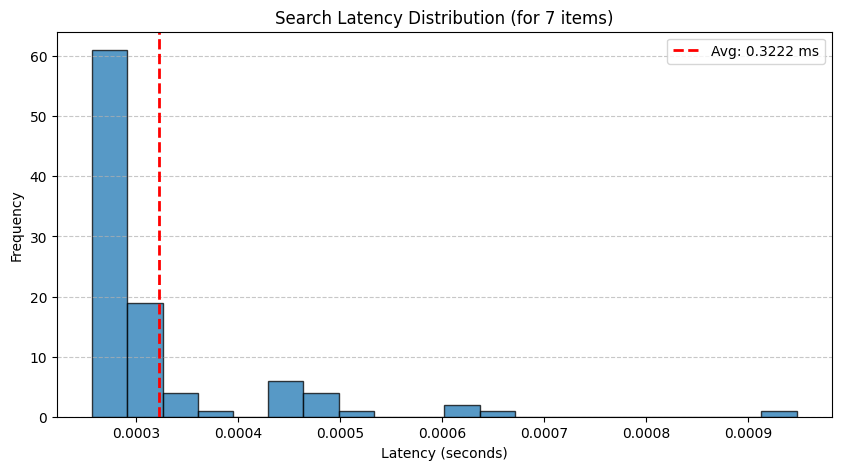

In [3]:
print("Installing required libraries...")
!pip install sentence-transformers pandas scikit-learn matplotlib -q
print("Libraries installed successfully!")


import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

print("Libraries imported.")

product_data = [
    {"name": "Boho Maxi Dress", "desc": "A flowy, floor-length dress with paisley patterns and earthy tones. Perfect for music festivals or a relaxed summer day.", "vibes": ["boho", "festival", "relaxed", "summer"]},
    {"name": "Sleek Urban Jumpsuit", "desc": "A sharp, tailored black jumpsuit. Minimalist design, clean lines. Ideal for a sophisticated city night out.", "vibes": ["urban", "chic", "minimalist", "sophisticated"]},
    {"name": "Cozy Knit Sweater", "desc": "An oversized, chunky knit pullover in a soft wool blend. Feels like a warm hug on a cold, rainy day.", "vibes": ["cozy", "relaxed", "winter", "comfort"]},
    {"name": "Vintage Denim Jacket", "desc": "A classic, slightly distressed denim jacket with a retro feel. Versatile and timeless, works with any casual outfit.", "vibes": ["vintage", "casual", "retro", "timeless"]},
    {"name": "Athleisure Jogger Set", "desc": "A matching set of soft joggers and a hoodie. Perfect for a quick run or running errands in style and comfort.", "vibes": ["athleisure", "sporty", "comfort", "casual"]},
    {"name": "Power-Move Blazer", "desc": "A structured, double-breasted blazer in a bold red color. Commands attention in the boardroom or at brunch.", "vibes": ["professional", "power", "chic", "bold"]},
    {"name": "Goth-Tech Ankle Boots", "desc": "Black leather boots with chunky soles and metallic buckles. Edgy, futuristic, and ready for an underground concert.", "vibes": ["goth", "techwear", "edgy", "futuristic"]}
]

df = pd.DataFrame(product_data)

print("---Our Product Catalog ---")
display(df)


print("\nLoading free embedding model (all-MiniLM-L6-v2)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded.")

print("\nGenerating embeddings for product descriptions...")

descriptions = df['desc'].tolist()
embeddings = model.encode(descriptions)
df['embedding'] = list(embeddings)

print("Embeddings generated successfully!")
print("\n--- Catalog with Embeddings (first 2 rows) ---")
display(df.head(2))

def find_vibe_matches(query, dataf, model, top_k=3, no_match_threshold=0.70):
    print(f"\nSearching for vibe: '{query}'...")

    query_embedding = model.encode(query)

    product_embeddings = np.array(dataf['embedding'].tolist())

    query_embedding_2d = np.array(query_embedding).reshape(1, -1)

    sim_scores = cosine_similarity(query_embedding_2d, product_embeddings)
    sim_scores = sim_scores[0]

    results_df = dataf.copy()
    results_df['similarity'] = sim_scores

    results_df = results_df.sort_values(by='similarity', ascending=False)
    top_score = results_df.iloc[0]['similarity']

    if top_score < no_match_threshold:
        return f"No strong vibe match found (top score: {top_score:.2f}). Try a different query!"

    top_matches = results_df.head(top_k)[['name', 'similarity', 'desc']]

    return top_matches

test_queries = [
    "energetic urban chic",
    "something cozy for a cold day",
    "edgy and futuristic"
]

for q in test_queries:
    matches = find_vibe_matches(q, df, model, no_match_threshold=0.70)
    print("--- Top Matches ---")
    display(matches)
    print("-" * 30)

print("\n--- Testing 'No Match' Fallback ---")
no_match_query = "food for my pet dog"
matches = find_vibe_matches(no_match_query, df, model, no_match_threshold=0.70)
print(matches)


print("\n--- Measuring Search Latency ---")
print("This test measures ONLY the cosine similarity search.")

test_query_embedding = model.encode("test query")
test_query_embedding_2d = np.array(test_query_embedding).reshape(1, -1)
product_embeddings_list = np.array(df['embedding'].tolist())

latencies = []
num_runs = 100

for _ in range(num_runs):
    start_time = time.time()
    cosine_similarity(test_query_embedding_2d, product_embeddings_list)
    end_time = time.time()
    latencies.append(end_time - start_time)

avg_latency = np.mean(latencies)
print(f"Average search latency over {num_runs} runs: {avg_latency * 1000:.4f} milliseconds")

plt.figure(figsize=(10, 5))
plt.hist(latencies, bins=20, alpha=0.75, edgecolor='black')
plt.title(f"Search Latency Distribution (for {len(df)} items)")
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.axvline(avg_latency, color='red', linestyle='dashed', linewidth=2, label=f'Avg: {avg_latency*1000:.4f} ms')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()